<div style=" border-bottom: 8px solid #00B2FF; overflow: hidden; border-radius: 10px; height: 60px; width: 100%; display: flex;">
  <div style="height: 100%; width: 100%; background-color: #3800BB; float: left; text-align: center; display: flex; justify-content: left; align-items: center; font-size: 40px; ">
    <b><span style="color: #FFFFFF; padding: 20px 20px;">LightGBM</span></b>
  </div>
</div>

<div class="alert" style="background-color: #FEDAD5; border-left: 8px solid #B12111; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">
  <h5 style="font-size: 16px; margin-bottom: 10px;">
    <strong> Contents </strong>
  </h5>
<hr>
  <p><font size="3" face="Arial" font-size="large">
  <ul type="square">
      
<li> LightGBM Classifier and its Parameters </li>
<li> Wrapping Data in a Dataset Class </li>
<li> Two Types of Models in LightGBM </li>
<li> Key Parameters </li>
<li> Tuning Optimal Hyperparameters </li>
<li> Built-in Visualization and Feature Importance </li>
<li> Custom Loss & Eval Functions </li>
<li> Conclusions and Summary </li>

  
  </ul>
  </font></p>

</div>

<div class="alert alert-warning">

### **Why do we need [LightGBM](https://lightgbm.readthedocs.io/en/v3.3.2/)?**
</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

- **`LightGBM`** has a similar interface to **`CatBoost`**
- It comes with its own quirks and hacks when it comes to tuning
- Naturally, it has unique advantages in functionality
- We'll use `LightGBM` as a deeper dive into boosting configuration
- Surprisingly, sometimes a specific boosting library outperforms the rest
- We'll go through some fancy features and leave the tricky nuances for practice

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

`LGBM (Light Gradient Boosted Machine)` was introduced by Ke G. et al. in their 2017 paper [“LightGBM: A Highly Efficient Gradient Boosting Decision Tree”](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree).

The implementation is based on two key ideas: `GOSS` and `EFB`.<br>
The framework is developed and maintained by Microsoft.

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

With `GOSS` (Gradient-based One-Side Sampling), we exclude a large portion of data instances with small gradients and use the remaining ones to estimate information gain. It has been shown that since instances with large gradients play a more critical role, `GOSS` can achieve a fairly accurate estimation using a significantly smaller dataset.<br>
<br>
</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

`EFB` or `Exclusive Feature Bundling` is a core idea behind LightGBM's efficiency. It helps reduce the number of features by bundling **mutually exclusive** sparse features — such as those produced by one-hot encoding. This technique significantly speeds up training by lowering dimensionality without losing important information.<br>
<div class="alert" style="background-color:rgb(255, 255, 255); border-left: 8px solid #B12111; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">
… we bundle mutually exclusive features (i.e., those that rarely take non-zero values at the same time) to reduce the number of features.
<br>
</div>
</div>


<div class="alert" style="background-color:rgb(255, 255, 255); border-left: 8px solid #B12111; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

We call our new implementation of `GBDT` using `GOSS` and `EFB` — `LightGBM`. Our experiments on several public datasets show that `LightGBM` speeds up training over traditional `GBDT` by more than 20 times while achieving nearly the same accuracy.
</div>

In [36]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', "{:,.2f}".format)
from classes import Paths

In [37]:
paths = Paths()
path = paths.quickstart_train
df = pd.read_csv(path)
print(df.shape)
df.head(10)

(2337, 17)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.74,"12,141,310.41",0.10,180.86,0.02,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.48,"18,039,092.84",0.00,187.86,12.31,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.77,"15,883,659.43",0.10,102.38,2.51,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.88,"16,518,828.77",0.10,172.79,-5.03,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.18,"13,983,174.66",0.10,203.46,-14.26,174,171
5,b12101843B,Skoda Rapid,economy,petrol,2.36,2013,42176,2018,48.99,engine_ignition,4.35,"10,855,890.99",0.10,180.89,-18.22,174,173
6,Q-9368117S,Nissan Qashqai,standart,petrol,5.32,2012,24611,2014,54.72,engine_overheat,4.39,"8,343,280.33",0.10,174.98,12.32,174,167
7,O-2124190y,Tesla Model 3,premium,electro,3.90,2017,116872,2019,50.40,gear_stick,4.71,"9,793,288.03",0.10,95.89,-8.94,174,139
8,h16895544p,Kia Sportage,standart,petrol,3.50,2014,56384,2017,33.59,gear_stick,4.51,"16,444,046.89",0.32,101.80,-1.16,174,170
9,K77009462l,Smart ForFour,economy,petrol,4.56,2013,41309,2018,39.04,gear_stick,4.38,"6,975,742.48",0.10,125.25,3.77,174,173


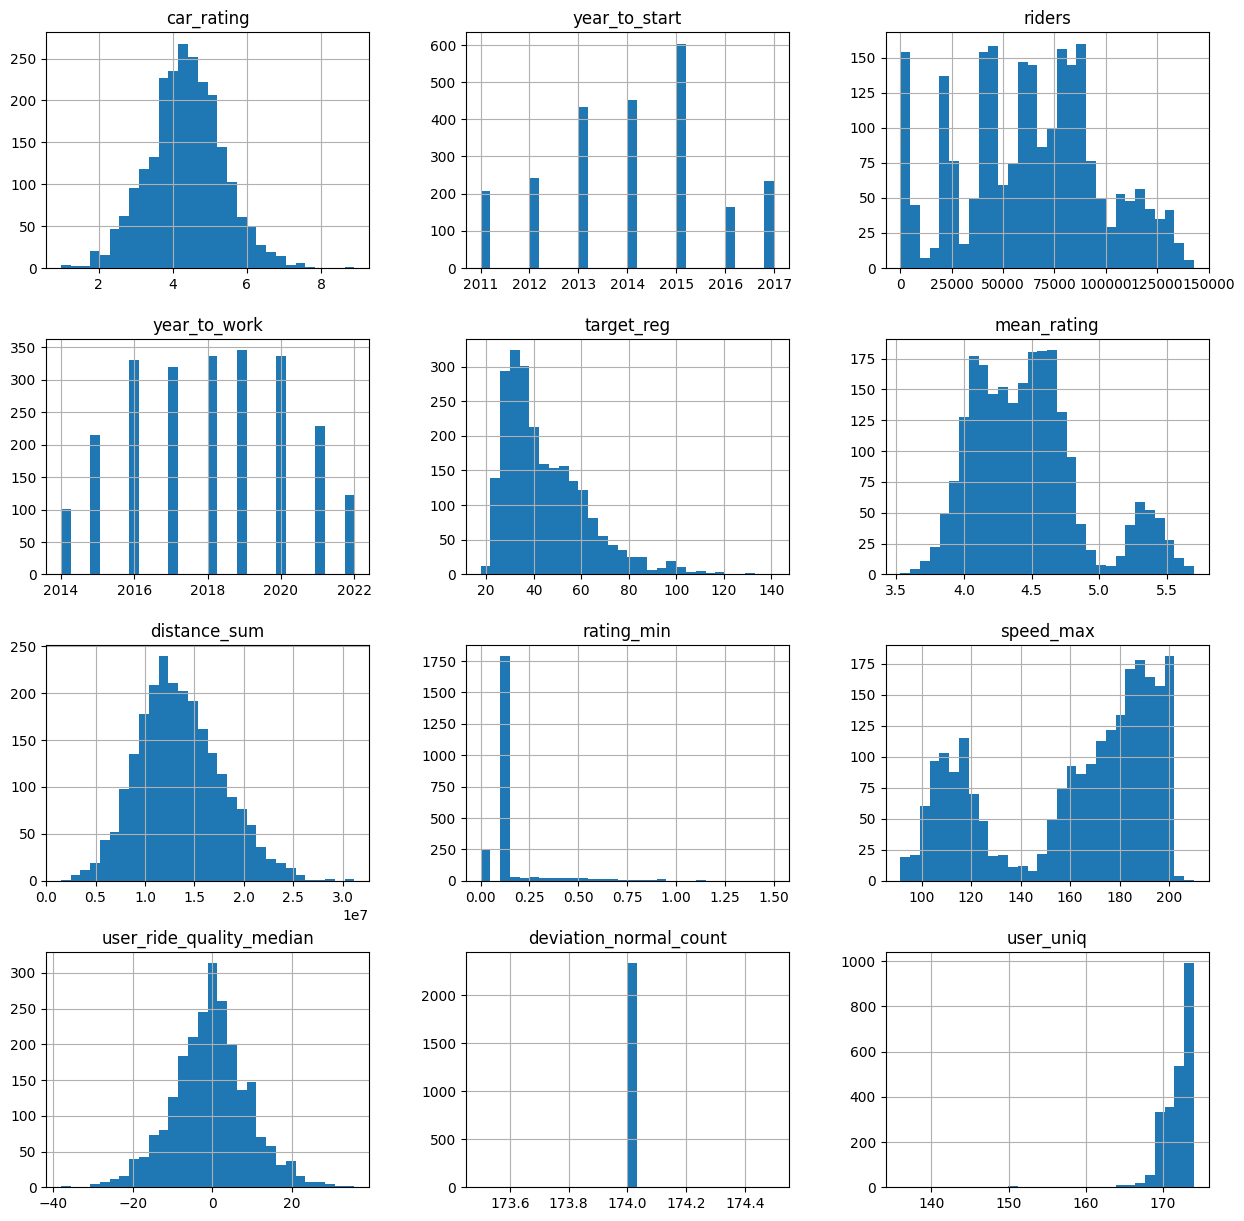

In [38]:
df.hist(
    figsize=(15,15)
    , layout=(-1, 3)
    , bins=30
);

In [39]:
# select categorical features
cat_cols = ["car_type", "fuel_type", "model"]
drop_cols = ["car_id", "target_reg", "target_class"]

X = df.drop(drop_cols, axis=1)
y = df["target_class"]

In [40]:
import lightgbm as lgb

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* Just like `CatBoost` has the `Pool` class for dataset creation, `LightGBM` provides a `Dataset` class for the same purpose. It's claimed to be highly memory-efficient, as it stores feature values as discrete bins instead of raw numbers.
* The number of bins can be adjusted during dataset creation using parameters like `max_bin` or `max_bin_by_feature`.
* According to the documentation, you can pass categorical features directly without one-hot encoding — the framework handles them internally, resulting in up to 8× faster training.
* ⚠️ However, this is implemented in a specific way: before creating the `Dataset` object, categorical features must be cast to the `int` type.
* ⚠️ The target variable (parameter `label`) also has type restrictions: it must be `int`, `float`, or `bool`.
</div>


In [41]:
cat_cols

['car_type', 'fuel_type', 'model']

In [42]:
X.loc[:, cat_cols]

,car_type,fuel_type,model
0,economy,petrol,Kia Rio X-line
1,economy,petrol,VW Polo VI
2,standart,petrol,Renault Sandero
3,business,petrol,Mercedes-Benz GLC
4,standart,petrol,Renault Sandero
...,...,...,...
2332,economy,petrol,Smart ForFour
2333,premium,petrol,Audi A4
2334,economy,petrol,Kia Rio
2335,standart,petrol,Renault Sandero


In [43]:
# let's cast the categorical features to int with a label encoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col])

# target also needs to be encoded
le_tar = LabelEncoder()
y = le_tar.fit_transform(y)

display(X.head(10).loc[:,cat_cols])
print("targets:", set(y))

,car_type,fuel_type,model
0,1,1,8
1,1,1,23
2,3,1,16
3,0,1,12
4,3,1,16
5,1,1,17
6,3,1,14
7,2,0,21
8,3,1,9
9,1,1,19


targets: {0, 1, 2, 3, 4, 5, 6, 7, 8}


<div class="alert" style="background-color: #FEF9E7; border-left: 8px solid #D4AC0D; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

**⚠️ Without the casting step above, the framework will throw an error when encountering non-numeric values in features.**
</div>

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y
                                                    , test_size=0.2
                                                    , random_state=42
                                                    , stratify=y
                                                    )
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1869, 14) (468, 14)
(1869,) (468,)


In [45]:
from lightgbm import Dataset

train_data = Dataset(
    X_train
    , y_train
    , categorical_feature=cat_cols
    , free_raw_data=False
)

# validation data for early stopping
val_data = Dataset(
    X_test
    , y_test
    , categorical_feature=cat_cols
    , free_raw_data=False
)

In [46]:
train_data.data

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
2023,7,1,1,3.44,2015,85781,2019,3.86,"12,702,841.01",0.10,186.00,-0.09,174,173
1116,15,3,1,5.56,2012,25972,2016,4.13,"25,195,589.10",0.10,187.65,-8.71,174,173
396,13,0,1,3.56,2015,80585,2018,4.23,"11,622,095.64",0.10,164.28,-13.61,174,172
1392,6,1,1,4.38,2012,21139,2018,5.41,"16,329,622.61",0.10,120.20,-6.62,174,173
152,22,1,1,4.30,2014,71807,2022,4.52,"15,302,309.96",0.10,101.74,-16.43,174,174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,9,3,1,4.14,2012,23529,2015,3.95,"13,801,992.47",0.10,191.02,6.53,174,173
403,17,1,1,3.34,2013,43291,2020,4.81,"11,139,433.82",0.10,165.00,-1.48,174,168
763,6,1,1,5.00,2015,78693,2021,4.36,"19,217,418.83",0.00,182.39,2.90,174,174
585,5,1,1,3.62,2013,44987,2022,3.95,"19,950,643.18",0.10,171.39,-1.42,174,171


Below are other important parameters:

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* `feature_name` — takes a list of strings defining the column names.
* `reference` — (`Dataset` or `None`, default=`None`) – If this is a validation `Dataset`, the training `Dataset` should be passed as a reference.
* `group` — used for ranking tasks (training a Ranker).
* `weight` — you can provide a list of weights (non-negative numbers) for each data instance or set them later using `set_weight()`.
* `params` — accepts a dictionary of parameters, where you can also set bin count (`max_bin` or `max_bin_by_feature`).
* `free_raw_data` (`bool`, optional, default=`True`) — controls whether raw data should be freed from memory after dataset creation.
</div>


<div class="alert" style="background-color:rgb(255, 255, 255); border-left: 8px solid #B12111; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

Numpy/Array/Pandas object is memory expensive. If you are concerned about your memory consumption, you can save memory by:

1. Set `free_raw_data=True` (default is True) when constructing the Dataset
2. Explicitly set `raw_data=None` after the Dataset has been constructed
3. Call `gc()`

</div>

<div class="alert alert-warning">

### **Two main ways to create and train a model in `LightGBM`**
</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

Although there are other ways too — each with its own convenience, pros, and cons.

* 1. The `train()` method from the `Booster` class — the simplest and most universal approach.
* 2. The `LGBMModel` class with familiar `fit()` and `predict()` methods, offering a **scikit-learn-like API** for training and prediction in `LightGBM`. This also allows integration with `sklearn` pipelines (e.g., for stacking).

We’ll explore both methods with examples and key parameters.
</div>

In [47]:
from lightgbm import LGBMClassifier, train  # ,LGBMRegressor

<div class="alert alert-warning">

### **Training a model using the `train()` method**
</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

The simplest way to train a model in `LightGBM` is to use the `train()` method. <br>
It takes a dictionary of parameters and a training dataset as input.<br>
After training, it returns a `Booster` object — this is the trained model, which can be used for future predictions.

Below are some of the key parameters of the `train()` method:

* `params` — a dictionary defining the model parameters. You just need to provide the objective function depending on the task type (classification/regression). We'll go over commonly used parameters in this dictionary later.
* `train_set` — a `Dataset` object containing features and target values.
* `num_boost_round` — number of boosting trees to use in the ensemble (default is 100).
* `valid_sets` — a list of `Dataset` objects used as validation sets. These are evaluated after each training iteration.
* `valid_names` — a list of strings (same length as `valid_sets`) used to name the validation sets. These names will be shown in the evaluation output and plots.
* `categorical_feature` — accepts a list of strings/integers or `'auto'`. If a list is provided, the specified columns in the dataset are treated as categorical.
* `verbose_eval` — `bool` or `int`. Controls how often evaluation metrics are printed during training.
</div>

In [48]:
params = {
    "objective": "multiclass",
    "num_class": 9,
    "verbosity": -1,
}

booster = train(
    params,
    train_set=train_data,  # Takes data in Dataset class format
    valid_sets=(val_data),
    # categorical_feature=cat_cols, 
    # LGBMDeprecationWarning: Argument 'categorical_feature' to train() is
    # deprecated and will be removed in a future release. 
    # Set 'categorical_feature' when calling lightgbm.Dataset() instead. 
    # See https://github.com/microsoft/LightGBM/issues/6435.
    # _emit_dataset_kwarg_warning("train", "categorical_feature")
    num_boost_round=10,
)

# For multiclass tasks, predict() returns class probabilities,
# so we take the argmax to get predicted class labels
test_preds = np.argmax(booster.predict(X_test), axis=1)
print("\nTest Accuracy: %.2f" % accuracy_score(y_test, test_preds))


Test Accuracy: 0.80


<div class="alert" style="background-color:rgb(255, 255, 255); border-left: 8px solid #B12111; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

`predict()`-method also has some parameters and can return `SHAP values`, `raw_score` etc. <br>

<font color="red">More</font> [(docs)](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Booster.html#lightgbm.Booster.predict)
</div>

<div class="alert alert-warning">

### **Training and creating model using `Booster`-class wrapper**
</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

Wrappers around the `Booster` class provide a **scikit-learn–like API** for training and prediction in `LightGBM`. You can create a model with a list of parameters and use the familiar `fit()` and `predict()` methods.<br>
The `params` dictionary used in the `train()` method can instead be passed directly to the wrapper constructor.<br>

Types of `Booster` wrappers:
* `LGBMModel` — a general-purpose wrapper for both classification and regression.  
  Example: `model = LGBMModel(objective="regression", n_estimators=10)`
* `LGBMClassifier` — same as `LGBMModel`, but specifically for classification tasks. It includes a `score()` method for evaluating accuracy and supports `predict()` for class labels and `predict_proba()` for class probabilities.
* `LGBMRegressor` — for regression tasks.
* `LGBMRanker` — for ranking problems.
</div>


In [49]:
# Note that the fit() method does not accept a Dataset class object
# therefore, we will pass the categorical column numbers to the cat_feature parameter
clf = LGBMClassifier(
    objective="multiclass",
    n_estimators=10,
    num_class=9,
    seed=42,
    cat_feature=[0, 1, 2], # we can't pass a list of column names
)

clf.fit(
    X_train,
    y_train,
    eval_set=[
        (X_test, y_test),
    ],
)

LGBMClassifier(cat_feature=[0, 1, 2], n_estimators=10, num_class=9,
               objective='multiclass', seed=42)

In [50]:
# In this case, the predict() method immediately returns the class label,
# so np.argmax() is not needed.
test_preds = clf.predict(X_test)
print("\nTest Accuracy: %.2f" % accuracy_score(y_test, test_preds))


Test Accuracy: 0.80


<div class="alert alert-warning">

### **`LightGBM` important parameters**
</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

A special feature of `LightGBM` is its support for several boosting algorithms, referred to as boosting types. The type is specified via the `boosting_type` argument.<br> Possible values:
* `gbdt` — gradient boosting over decision trees (default);

<div class="alert alert-info">

- GBDT stands for Gradient Boosted Decision Trees. It's the core boosting algorithm behind LightGBM and many other libraries.
- Here’s how it works in a nutshell:
    - Models are built sequentially.
    - Each new tree tries to correct the errors of the previous ensemble by minimizing a loss function (e.g., log-loss for classification).
    - Instead of fitting directly to the target, each tree fits to the gradient of the loss with respect to the model’s predictions — hence the name.
    - It’s the default boosting_type in LightGBM.
</div>

* `dart` — dropout meets `MART`, giving us `DART` (similar to [`dropout`](https://en.wikipedia.org/wiki/Dropout_(neural_networks)) layers in neural networks);

<div class="alert alert-info">

- In LightGBM, DART stands for Dropouts meet Multiple Additive Regression Trees.
- It's a variant of Gradient Boosting that introduces the concept of dropout (inspired by neural networks) into tree ensembles. During training, some trees are randomly dropped when computing the prediction for each iteration. This helps reduce overfitting by preventing the model from relying too heavily on specific trees.
- In short: `DART = GBDT + dropout`
- It increases model diversity and improves generalization, especially useful when overfitting is a concern.
</div>

* `goss` — Gradient-based One-Side Sampling (`GOSS`);

<div class="alert alert-info">

- GOSS stands for Gradient-based One-Side Sampling.
- It's a boosting type in LightGBM that improves training speed without sacrificing much accuracy. The core idea is:
    - Keep data points with large gradients (they're more "informative").
    - Randomly sample from those with small gradients (less impactful).
    - This creates a biased subsample that still preserves the integrity of gradient-based learning.
    - By focusing more on the "difficult" examples, GOSS reduces the training data size and accelerates learning.
</div>

* `rf` — `Random Forest`

<div class="alert alert-info">

In LightGBM, `rf` stands for Random Forest boosting type.
Unlike traditional Random Forests which train trees independently, LightGBM's rf trains trees sequentially (like in boosting), but uses bagging (random subsets of data) and feature subsampling to add randomness. It's essentially a boosted version of Random Forests, useful when you want to `introduce more variance and reduce overfitting`.
</div>
</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">


`objective` — this parameter lets us define the objective (loss) function used for the current task. Its default value is `regression`. Currently, 16 objective functions are supported. Below is a list of commonly used values for this parameter.

`regression` (L2 loss), `regression_l1` (L1 loss), `tweedie`, `binary`, `multiclass`, `multiclassova`, `cross_entropy`, `lambdarank` <br>

[Other available objective functions](https://lightgbm.readthedocs.io/en/latest/Parameters.html#objective)
</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

`metric` — this parameter defines the evaluation metrics to be calculated on the validation datasets. You can provide more than one metric, and all will be computed for the evaluation sets. Below is a list of commonly used values for this parameter.

`rmse`, `l2`, `l1`, `binary_logloss`, `multi_logloss`, `auc`, `cross_entropy` <br>

[Other available metrics](https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric)

</div>

<div class="alert alert-warning">

### **More parameters**
</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

**Basic parameters**, without `max_depth` 🦄

`num_iterations` — alias for `num_boost_round`, defines the number of boosting rounds (trees). Default is 100. <br>
`learning_rate` — controls the step size at each boosting iteration. Default is 0.1. <br>
`num_leaves` — sets the maximum number of leaves per tree. Default is 31. <br>
</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

**Tree Regularization**    

* `max_depth` — this parameter allows us to set the maximum depth allowed for trees in the ensemble. The default is -1, which allows trees to grow as deep as possible.  
* `min_data_in_leaf` — specifies the minimum number of data points (samples) that a leaf can contain. Helps control overfitting. Default is 20.  
* `bagging_fraction` — a float from 0 to 1 that defines what portion of the training data is randomly sampled for each iteration. Helps reduce overfitting. Default is 1.0.  
* `feature_fraction` — a float from 0 to 1 that tells the algorithm what fraction of features to randomly select at each iteration. Default is 1.0 (i.e., all features are used).  
* `extra_trees` — a boolean that specifies whether to use extremely randomized trees.  

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* `force_col_wise` — this parameter accepts a boolean value that determines whether to force histogram construction by columns during training. If your data has a large number of columns, setting this to `True` can speed up training by reducing memory usage.  
* `force_row_wise` — this parameter accepts a boolean value that determines whether to force histogram construction by rows during training. If your data has a large number of rows, setting this to `True` can speed up training by reducing memory usage.  

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* `early_stopping_round` — accepts an integer specifying the number of rounds with no improvement on the last validation dataset's evaluation metric before training is stopped early.

* `num_class` — required for multiclass classification tasks; specifies the total number of classes.

* `is_unbalance` — a boolean flag that should be set to `True` if the dataset is imbalanced. It is useful for binary and multiclass classification tasks.


</div>

<div class="alert" style="background-color: #FEF9E7; border-left: 8px solid #D4AC0D; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

This is by no means a complete list of parameters — just the most important ones.  
[Full list of parameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html)
</div>

In [51]:
# let's see how the accuracy changes depending on the type of boosting
boostings = ["gbdt", "dart", "goss"]

for name in boostings:
    clf = LGBMClassifier(
        objective="multiclass",
        n_estimators=100,
        learning_rate=0.1,
        num_class=9,
        reg_alpha=0.5,
        reg_lambda=0.3,
        seed=42,
        cat_feature=[0, 1, 2],
        data_sample_strategy=name if name == 'goss' else 'bagging',
        boosting_type=name if name != 'goss' else 'gbdt',
        verbose=-1,
    )
    clf.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
    )
    test_preds = clf.predict(X_test)
    print("{} accuracy: {:.2f}".format(name, accuracy_score(y_test, test_preds)))

gbdt accuracy: 0.79
dart accuracy: 0.78
goss accuracy: 0.78


As you can see, the differences are minor. For optimal hyperparameter tuning, check out the lesson on **Optuna**.  
Here's the [official tuning guide](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) from the LightGBM creators.

<div class="alert alert-warning">

### **Hyperparameter Tuning. How?**
</div>

<div class="alert alert-warning">

**To increase model accuracy:** 
<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* Use a large `max_bin` (may slow down training)  
* Decrease `learning_rate`, increase `num_iterations`  
* Increase `num_leaves` (may cause overfitting)  
* Try `dart`

</div>

</div>

<div class="alert alert-warning">

**To reduce overfitting:** 
<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

* Decrease `max_bin` and `num_leaves`  
* Use `min_data_in_leaf` and `min_sum_hessian_in_leaf`  
* Apply [bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating) with `bagging_fraction` and `bagging_freq`  
* Use feature subsampling with `feature_fraction`  
* Try `lambda_l1`, `lambda_l2`, `min_gain_to_split`, and `extra_trees` for regularization  
* Set `max_depth` to limit tree growth  

</div>

</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

⚠ About `max_depth`: LightGBM builds **asymmetric trees**, unlike many other boosting algorithms (a claimed killer feature by the devs), so by default `max_depth = -1` (unlimited).  
However, to avoid growing trees indefinitely and overfitting—especially on small datasets—it's recommended to use other depth-limiting parameters: `num_leaves`, `min_data_in_leaf`, `min_sum_hessian_in_leaf`, `min_data_in_bin`, and `min_gain_to_split`.  
Use `max_depth` **either** on very small datasets (to prevent overfitting) **or** on very large ones (to speed up training).  
</div>

<div class="alert alert-warning">

### **`Early stopping` or when to stop**
</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

To use `early_stopping`, you must provide at least one validation dataset in `valid_sets`.  
LightGBM supports two main approaches for early stopping:

* **1. Use `early_stopping_round`:**  
Stops training if the validation score doesn’t improve after a given number of rounds.

* **2. Use `callbacks` in `train()`:**  

<div class="alert" style="background-color:rgb(0, 0, 0); border-left: 8px solid #B12111; padding: 14px; border-radius: 8px; font-size: 14px; color:rgb(255, 255, 255);">

```python
bst = lgb.train(param,
                train_data,
                num_round,
                valid_sets=valid_sets,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])
```
</div>

We can also define a custom callback for complex logic—e.g., when multiple metrics need to improve in different directions. 
See the [docs](https://lightgbm.readthedocs.io/en/latest/Parameters.html#early_stopping_round) for details.

</div>

In [52]:
# let's use the functionality of early stopping
clf = lgb.LGBMClassifier(
    objective="multiclass",
    n_estimators=100,
    learning_rate=0.1,
    num_class=9,
    seed=42,
    cat_feature=[0, 1, 2],
    early_stopping_round=5,
    verbose=-1,
)

clf.fit(
    X_train,
    y_train,
    eval_set=[
        (X_test, y_test),
    ],
)

LGBMClassifier(cat_feature=[0, 1, 2], early_stopping_round=5, num_class=9,
               objective='multiclass', seed=42, verbose=-1)

In [53]:
# need to be said that the model is returned with the best iteration after stopping
clf.best_iteration_

28

<div class="alert alert-warning">

### **Saving and Loading Models**
</div>

<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

It’s important to note that when working with models trained using `LGBMModel`, `LGBMRegressor`, or `LGBMClassifier`, you first need to extract the underlying `Booster` instance using the model’s `booster_` attribute before saving. These classes don’t directly provide save/load methods. Only the `Booster` class supports this functionality.


</div>


<div class="alert" style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 14px; border-radius: 8px; font-size: 14px; color: #000000;">

**`LightGBM`** provides the following methods for model persistence:
* `save_model()` — saves the model to a file.
* `model_to_string()` — returns a string representation of the model, which can be saved to a text file.
* `lightgbm.Booster()` — constructor to manually create a `Booster` object. It supports:
    - `model_file` — path to a file containing a trained model.
    - `model_str` — a string (from `model_to_string()`) representing the model.

Let’s save the trained model to disk and then load it back.
</div>

In [54]:
# get the Booster object
booster = clf.booster_
booster.save_model("lgb.mod")

In [55]:
# it will be an instance of the Booster class and
# accordingly, the predict() method will again give probabilities
# that is why we use argmax()
loaded_booster = lgb.Booster(model_file="lgb.mod")
test_preds = np.argmax(loaded_booster.predict(X_test), axis=1)
print("Test Accuracy: %.2f" % accuracy_score(y_test, test_preds))

Test Accuracy: 0.79
